# News preprocessing

Pre-processed to remove URLs, symbols. That is, things that are not words.

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#Nicer style
style.use('seaborn') 

In [3]:
import re #regexp

NLTK (Natural Language Tool Kit) Tokenizer based on regular expressions. 

In [4]:
from nltk.tokenize import RegexpTokenizer

### Cleaning the dataset
We load the news dataset

Index(['id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'keywords', 'meta_keywords',
       'meta_description', 'tags', 'summary'],
      dtype='object')
Index(['id', 'domain', 'type', 'url', 'content', 'scraped_at', 'inserted_at',
       'updated_at', 'title', 'authors', 'keywords', 'meta_keywords',
       'meta_description', 'tags', 'summary'],
      dtype='object')


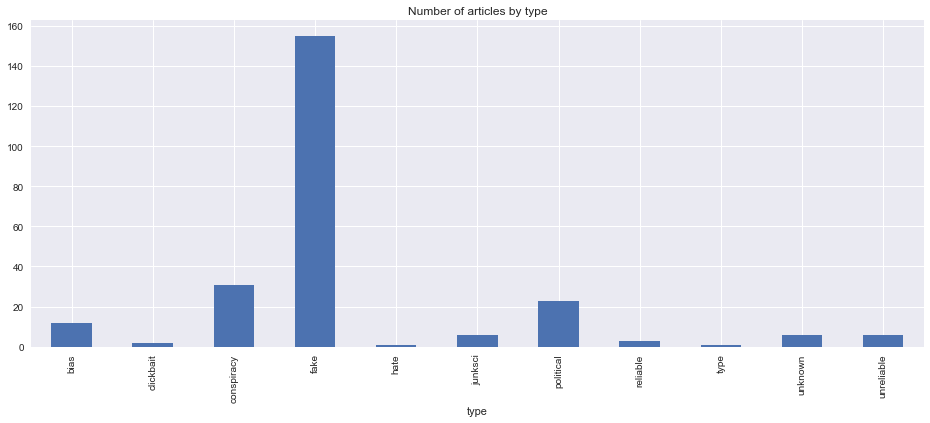

In [5]:
# news = pd.read_csv("../data/news_sampled.csv", nrows=200_000)
news = pd.read_csv("news_cleaned_2018_02_13.csv", nrows=200_000, index_col=0)
news = news[news['type']!='bias']
news = news[news['type']!='clickbait']

print(news.columns)
#Load dataset for avoiding unbalance.
click_bias = pd.read_csv("click_bias_only.csv", nrows=200_000, index_col=0)
print(click_bias.columns)

news = pd.concat([news, click_bias])
# print(news.applymap(type)) # Print unique types for each column
del(click_bias)

fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

news = news[['type', 'content', 'title']]

#Remove columns with NaNs 
news = news.dropna()
# print(news.applymap(type)) # Print unique types for each column

In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     246 non-null    object
 1   content  246 non-null    object
 2   title    246 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


We fixed the bias imbalance of the dataset. 

In [9]:
news.shape

(246, 3)

In [10]:
news = pd.concat([news[news['type'] == 'bias'].head(60000).copy(), news[news['type'] != 'bias'].copy()])

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

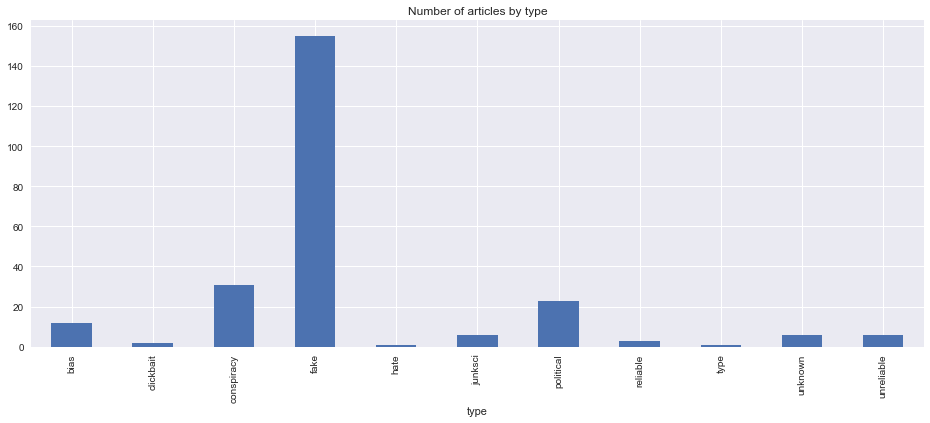

In [11]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [12]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

We clean the fields that we will use: Title and content 

In [13]:
#Clean content
news['content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
#Clean title
news['title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

#Select only news with text
news = news[news['title'].str.len() >= 1]
news = news[news['content'].str.len() >= 1]

C:\Python\lib\site-packages\swifter\swifter.py:35: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/246 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/246 [00:00<?, ?it/s]

In [14]:
news.head(3)

,type,content,title
12,bias,"[President, Trump, right, with, Rep, Robert, L...","[In, Calling, Out, News, Donald, Trump, Engage..."
114,bias,"[Here, I, outline, one, of, the, core, philoso...","[Anatoly, Karlin, Archive]"
167,bias,"[I, Was, Silent, When, They, Came, for, You, S...","[I, Will, Stand, Up, For, You, If, You, Stand,..."


The news is organized in the following categories 

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

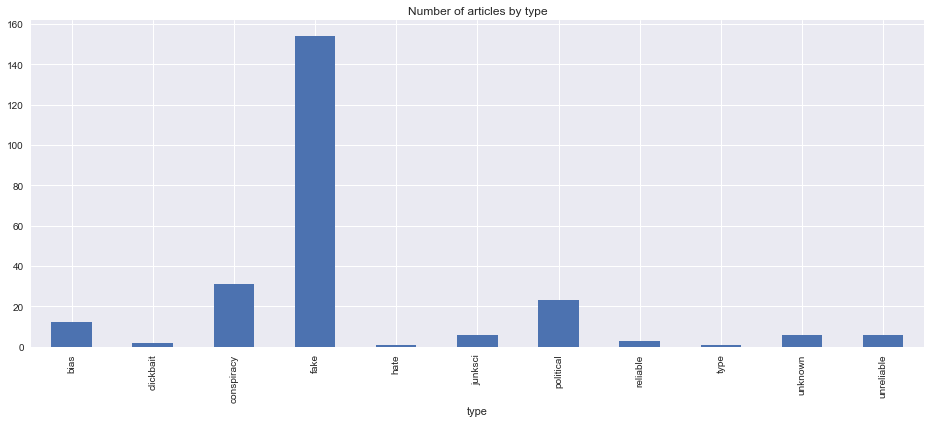

In [15]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

From here, and based on the descriptions of [OpenSources](http://www.opensources.co) (from which the dataset labels have been taken) we can group several categories. For instance:
   * **Fake**
       * conspiracy
       * junksci
       * rumor
       * unknown
       * satire
       * hate
       * unreliable
       * fake
   * **Bias**
       * bias
   * **Truth**
       * reliable
       * political
   * **Clickbait**
       * clickbait

We turn groups into new ones

In [16]:
def convert_tag(tag):
    """Convert a tag to one of the three groups (fake, truth, clickbait)"""
    new_tag = None
    fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake','clickbait'])
    truth = set(['reliable', 'political','bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    return new_tag

In [17]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

C:\Python\lib\site-packages\swifter\swifter.py:35: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/245 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

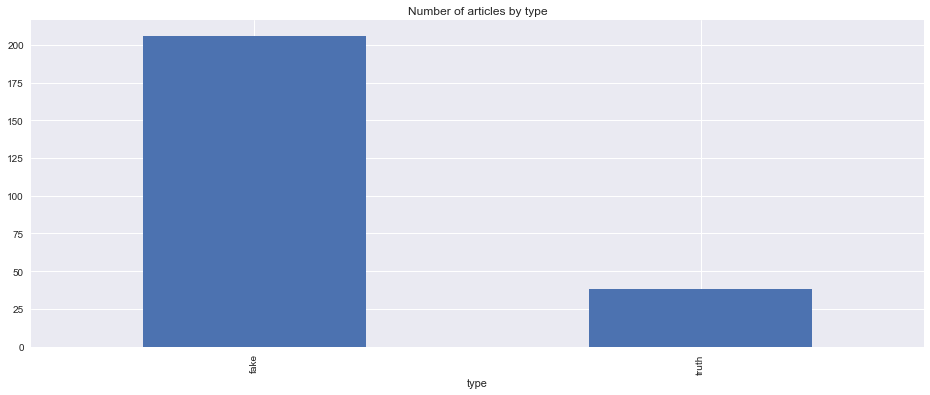

In [18]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

The dataset is quite unbalanced. In order to properly train the neural networks, the number of samples per category must be more equal. 

In this case, we create a function to select the examples we want for each category. Those that are underrepresented will be oversampled. 

In [19]:
def equalize_categories(dataframe, categories):
    """
    This function takes a dataset and sets the number of samples of each
    class to the specified in the categories param
    :param dataframe (pandas DF)
    :param categories (dict) dictionary with the number of samples desired per class
    """
    #Copy dataframe structure
    df = dataframe.iloc[0:0]
    
    for cat in categories:
        selection = dataframe[dataframe['type'] == cat]
        count = selection['type'].count()
        if count >= categories[cat]:
            df = pd.concat([df, selection.head(categories[cat])])
        else:
            #Add n times the block
            block = dataframe.iloc[0:0]
            times = int(categories[cat] / count)    
            for i in range(times+1):
                block = pd.concat([block, selection])
            #Remove the remaining
            df = pd.concat([df, block.head(categories[cat])])
    
    return df

In [21]:
cats = {
    'fake': 50_000,
    'truth': 50_000
}
equalized = equalize_categories(news, cats)

<AxesSubplot:title={'center':'Number of articles by type'}, xlabel='type'>

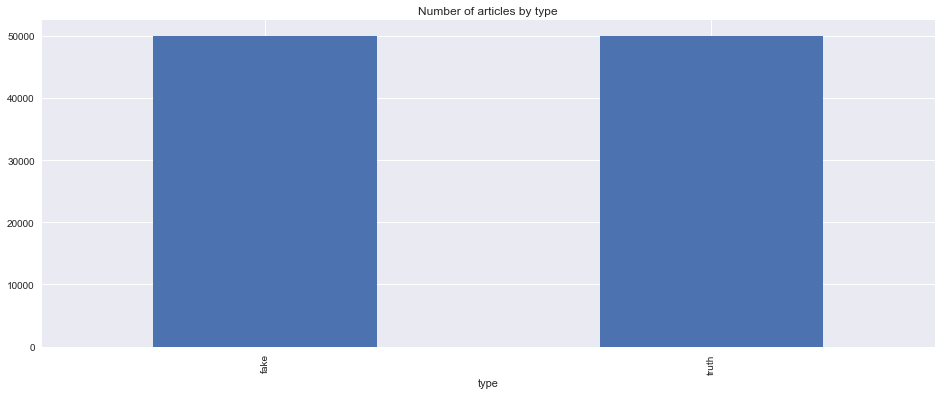

In [22]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
equalized.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

In [23]:
#del(news)
news = equalized.copy()
del(equalized)

### Word2Vec

We load the vectors of a model trained by Google with the texts of millions of news 

In [33]:
from gensim.models.keyedvectors import KeyedVectors

In [36]:
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True,
                                          limit=50000)

An example of predicting words similar to "Trump" 

In [37]:
model.most_similar("Trump")

[('Donald_Trump', 0.8103920221328735),
 ('Apprentice', 0.47915542125701904),
 ('Paladino', 0.4655587375164032),
 ('Snooki', 0.4468839764595032),
 ('Harrah', 0.44451743364334106),
 ('MGM_Mirage', 0.4422535300254822),
 ('Vince_McMahon', 0.44097134470939636),
 ('Limbaugh', 0.4399239420890808),
 ('Palin', 0.4383709132671356),
 ('Giuliani', 0.4358449876308441)]

We then convert the words from the news headline and content to the Word2Vec vocabulary indexes. 

In [38]:
news['title'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [39]:
news['content'] = news.progress_apply(lambda r: 
                        [model.vocab[x].index for x in r['content'] if x in model.vocab], axis=1)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Delete the articles without title (Word2Vec did not have the original words) 

In [40]:
news = news[news['title'].map(len) >= 1]

In [41]:
#Reset index
news = news.reset_index().drop("index", axis=1)


But there is a **problem**: The network input cannot be variable. To solve this, it is necessary to add padding to all the arrays, so that they all have a physical length. 

In [42]:
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] #Truncate
    else:
        #Pad
        array += [0]*diff_token #Pad
        
    return array  

You need to find a `token_len` that is sufficient to generally cover the length of all items. 

Pandas Apply:   0%|          | 0/96054 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Number of tokens in the article'}, ylabel='Frequency'>

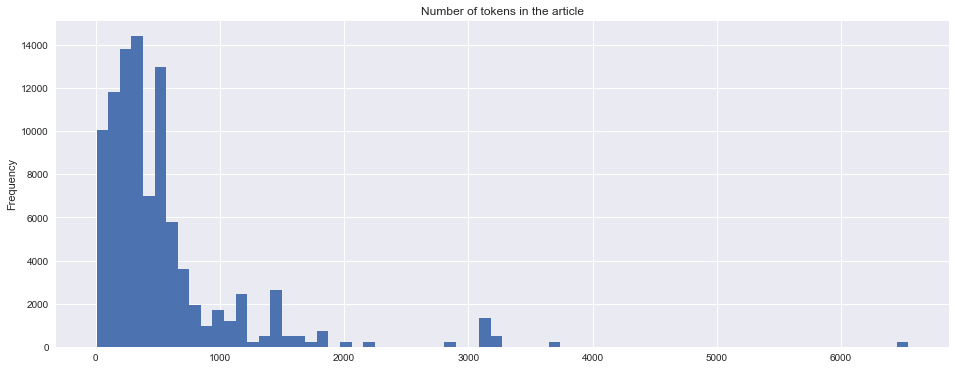

In [43]:
# Length in tokens of each news 
tokens_numbers = news.swifter.apply(lambda row: len(row['content']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 70, ax=ax)

In [45]:
print("Average number of tokens per item : {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item : {}".format(int(np.std(tokens_numbers))))
print("Median tokens per item : {}".format(int(np.median(tokens_numbers))))

Average number of tokens per item : 541
Standard deviation of tokens per item : 642
Median tokens per item : 365


In [46]:
max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))

Chosen token window: 1827 - Covers 96.35413413288359% of the dataset


In [47]:
n_tokens = max_tokens

In [48]:
news['content'] = news.apply(lambda r: pad_array(r['content'], n_tokens) , axis=1) #n_tokens

Same for titles 

Average number of tokens per item: 7
Standard deviation of tokens per item: 3
Median tokens per item : 8
Chosen token window: 15 - Covers 98.99015137318592% of the dataset


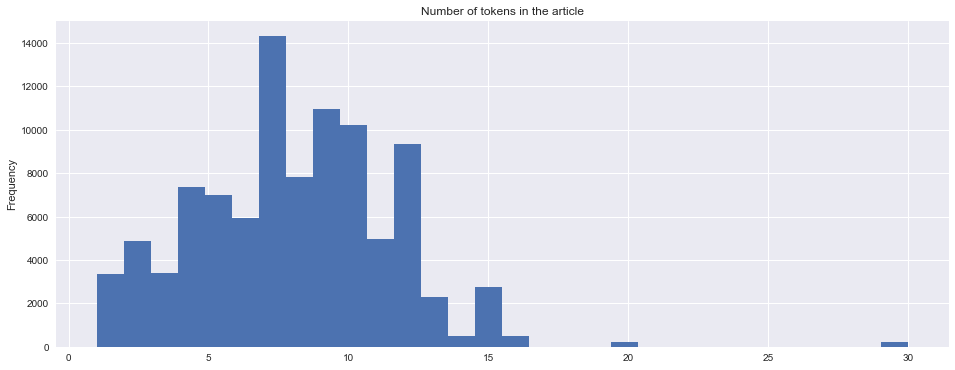

In [49]:
# Longitud en tokens de cada noticia
tokens_numbers = news.apply(lambda row: len(row['title']), axis = 1)

fig, ax = plt.subplots(1,1, figsize=(16,6))
tokens_numbers.plot.hist(title="Number of tokens in the article", bins = 30, ax=ax)

print("Average number of tokens per item: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per item: {}".format(int(np.std(tokens_numbers))))
print("Median tokens per item : {}".format(int(np.median(tokens_numbers))))

max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
max_tokens = int(max_tokens)

n_tokens = max_tokens

percent_tokens = tokens_numbers[tokens_numbers <= max_tokens].count() / tokens_numbers.count()
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens*100))

In [50]:
news['title'] = news.progress_apply(lambda r: pad_array(r['title'], n_tokens) , axis=1)

Pandas Apply:   0%|          | 0/96054 [00:00<?, ?it/s]

### Convert Target Variable to One Hot Encoding 

In [51]:
encoder = LabelBinarizer().fit(list(news['type']))
news['one_hot_label'] = news.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

In [52]:
news.head()

,type,content,title,one_hot_label
0,fake,"[3594, 11, 325, 1514, 23, 109, 43, 58, 3651, 3...","[2468, 35121, 26725, 19170, 6607, 5, 1514, 180...",[0]
1,fake,"[10826, 4409, 8, 228, 10872, 2342, 153, 28, 55...","[10826, 4409, 8, 228, 10872, 0, 0, 0, 0, 0, 0,...",[0]
2,fake,"[7646, 48350, 32125, 73, 210, 11, 15360, 7316,...","[7646, 48350, 32125, 73, 210, 11, 15360, 7316,...",[0]
3,fake,"[305, 2612, 13878, 10, 1401, 2635, 37, 196, 2,...","[1781, 7, 5606, 28350, 149, 25851, 192, 400, 1...",[0]
4,fake,"[1154, 6312, 19, 1938, 749, 63, 121, 15304, 26...","[2182, 23325, 3170, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[0]


We save the processed dataset as .pickle (python object serialized). 

In [54]:
news.to_pickle('news_proc_12_3_19.pickle')

We save the processed dataset as `.csv`. 

In [55]:
news.to_csv('news_proc_8_3_19.csv', sep=';')

In [56]:
from ast import literal_eval


In [57]:
news = pd.read_csv('news_proc_8_3_19.csv', 
                       sep=';', converters={'content':literal_eval, 
                                       'title':literal_eval, 
                                       'one_hot_label':literal_eval})

In [58]:
#TEST TO LOAD AND THEN MAKE A PARALLELIZED APPLY 

In [59]:
news = pd.read_csv('news_proc_8_3_19.csv', sep=';')

In [60]:
news['title'] = news.swifter.apply(lambda r: literal_eval(r['title']), axis= 1)
news['content'] = news.swifter.apply(lambda r: literal_eval(r['content']), axis= 1)
news['one_hot_label'] = news.swifter.apply(lambda r: literal_eval(r['one_hot_label']), axis= 1)

Pandas Apply:   0%|          | 0/96054 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96054 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/96054 [00:00<?, ?it/s]